In [152]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
import matplotlib.pyplot as plt
import sunRay.SunRayRunAnisScatSWind as anisRaySWind
import sunRay.statisticalRays as raystat
import numpy as np
from sunRay import solarWind
#plotly 3d check

1.6.0
True


In [153]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [154]:
torch.__config__.parallel_info()

'ATen/Parallel:\n\tat::get_num_threads() : 4\n\tat::get_num_interop_threads() : 16\nOpenMP 201511 (a.k.a. OpenMP 4.5)\n\tomp_get_max_threads() : 4\nMKL not found\nMKLDNN not found\nstd::thread::hardware_concurrency() : 32\nEnvironment variables:\n\tOMP_NUM_THREADS : [not set]\n\tMKL_NUM_THREADS : [not set]\nATen parallel backend: OpenMP\n'

In [161]:
#2.10428659  2.0
#1.75  1.1

#[eps0.102]_[alpha0.15743]
#[eps0.354]_[alpha0.15743]
#[eps0.102]_[alpha0.802]
#[eps0.354]_[alpha0.802]


#r=9-> 0.954
#r=30->

photon_N = 2000
eps_cur = 0.2
alpha_cur = 0.2
rr0 = 9

(steps_N, collect_N,  photon_N, start_r,  start_theta, 
            start_phi,  f_ratio, epsilon ,  anis, asym,  omega0, freq0, 
            t_collect, tau, r_vec_collect_local,  k_vec_collect_local,  
            tau_collect_local,dk_refr_collect, dk_scat_collect
            ) = anisRaySWind.runRays(steps_N  = -1 , collect_N = 200, t_param = 20.0, 
            photon_N = photon_N, 
            start_r = rr0 ,f_ratio  = 1.1,
            start_theta = -0/180.0*np.pi, start_phi  = 0/180.0*np.pi,
            epsilon = eps_cur, anis = alpha_cur,
            asym = 1.0, Te = 86.0, Scat_include = True, Show_param = True,
            Show_result_k = False, Show_result_r = False,  verb_out = True,
            sphere_gen = True, num_thread =4, early_cut= True ,
            ignore_down=True,Absorb_include=True,dev_u = torch.device('cuda:1'),
            save_npz = True, data_dir='/HDD/SunRay/',save_level=1,dk_record=False,
                                    debug=False)
    


----------------------------------
Frequency : 0.9544MHz
Compute with : cuda:1
----------------------------------
tensor([696.4655], device='cuda:1')
Refraction dt : 5.334214674020393
Scattering dt : 17.5604137456328
Absorb Col    : 0.0006889819324748926
Absorb  t     : 24065.568


 73%|███████▎  | 6320/8675 [00:41<00:15, 151.57it/s]


Traced final t : 530.415 s
warning (r):2000


In [ ]:
2e2*0.5**4

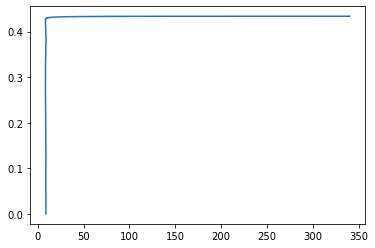

In [138]:
plt.plot(np.sqrt(np.sum(r_vec_collect_local[:,:,2]**2,axis=1)) ,dk_refr_collect[:,1])

In [128]:
xs=torch.tensor([1e-9],dtype=float)
ys=torch.tensor([-1e-9],dtype=float)
zs=torch.tensor([start_r])

rr_cur = torch.sqrt(xs**2+ys**2+zs**2)

fi0 = torch.atan2(xs,zs)
theta0 = torch.acos(ys/rr_cur)

(BxE,ByE,BzE)=solarWind.ParkerBxyzEarth(rr_cur,theta0,fi0)

BB = torch.sqrt(BxE**2+ByE**2+BzE**2)
fi=torch.atan2(BzE,ByE)	
sintheta=torch.sqrt(1.-BxE**2/BB**2)
costheta=BxE/BB

In [129]:

from sunRay.parameters import c,c_r,R_S  # physics parameters
c_r

0.4307471264367816

In [139]:
np.sqrt(np.sum((r_vec_collect_local)**2,axis=1)).shape

(121, 2000)

FileNotFoundError: [Errno 2] No such file or directory: 'img_swind/movie_ray/rays_wind0000.png'

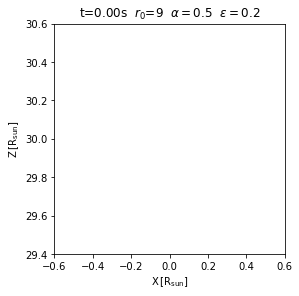

In [140]:
vec0=0.3

for idx in range(collect_N):
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_axes((0.1, 0.1, 0.8, 0.8), frameon=True, aspect='equal',
        adjustable='box', xlabel=r'$\rm X\, [R_{{sun}}]$',ylabel=r'$\rm Z\, [R_{sun}]$',
        title=r't='+str(t_collect.numpy()[idx])[0:4]+'s  $r_0$='+str(rr0)+r'  $\alpha=$'+str(alpha_cur)+r'  $\epsilon=$'+str(eps_cur))
    ax = plt.gca()

    plt.arrow(xs,zs,vec0*sintheta*torch.cos(fi),vec0*costheta,
              head_width=0.035, head_length=0.1,
             color='C0',alpha=1,zorder=1e6)

    vec0=0.3
    ax.plot(r_vec_collect_local[0:idx,0,:],r_vec_collect_local[0:idx,2,:],color="k", 
            linewidth=1, alpha=0.02)
    ax.scatter(r_vec_collect_local[idx,0,:],r_vec_collect_local[idx,2,:],color="C1", 
            marker='.',s=0.5,zorder=1e5,linewidth=0.2)
    
    
    #ax.plot([xs,xs+vec0*sintheta*torch.cos(fi)],[zs,zs+vec0*costheta])
    ax.axis('equal')
    ax.set_xlim([-0.6,0.6])
    ax.set_ylim([29.4,30.6])

    fig.savefig('img_swind/movie_ray/rays_wind'+str(idx).rjust(4,'0')+'.png',bbox_inches='tight',dpi=400)
    plt.close()

In [141]:
(r_vec_stat_avail,k_vec_stat_avail,t_reach_stat_avail,tau_stat_avail,
                r_vec_0, k_vec_0) =  raystat.reduct_lv1(
                    photon_N,r_vec_collect_local,k_vec_collect_local,
                    t_collect,tau_collect_local,omega0,num_t_bins=60)
                    
#(r_vec_stat_avail,k_vec_stat_avail,t_reach_stat_avail,dk_refr_avail,
#                r_vec_0, k_vec_0) =  raystat.reduct_lv1(
#                    photon_N,r_vec_collect_local,k_vec_collect_local,
#                    t_collect,dk_refr_collect,omega0,num_t_bins=60)
                    
#(r_vec_stat_avail,k_vec_stat_avail,t_reach_stat_avail,dk_scat_avail,
#                r_vec_0, k_vec_0) =  raystat.reduct_lv1(
#                    photon_N,r_vec_collect_local,k_vec_collect_local,
#                    t_collect,dk_scat_collect,omega0,num_t_bins=60)

warning (r):2000


In [142]:

r_vec_end = r_vec_collect_local[-1,:,:].reshape(3,-1)
r_vec_end

array([[ 256.10794 ,  108.287254, -273.57596 , ..., -107.52634 ,
        -230.42162 ,   82.88531 ],
       [ 257.2484  ,   92.55579 ,  -59.44166 , ...,  350.99997 ,
        -193.01353 ,   73.54531 ],
       [ 104.14871 ,  363.61316 ,  193.4483  , ...,  -37.265583,
         242.56245 ,  371.8718  ]], dtype=float32)

In [143]:
rr_end = np.sqrt(np.sum(r_vec_end**2,axis=0))
find_small_1e3(rr_end)

235.18279

In [144]:
find_small_1e3 = lambda arr:  np.sort(arr)[int(arr.shape[0]*1e-3)]

In [145]:
ang_rot = 0

# Important !!! rotate the initial point
r_vec_rot,k_vec_rot = raystat.rotateCoordKX(r_vec_stat_avail,k_vec_stat_avail,-ang_rot*np.pi/180)
r_vec0_rot,k_vec0_rot = raystat.rotateCoordKX(r_vec_0,k_vec_0,-ang_rot*np.pi/180)

(x_im_stat,y_im_stat,t_reach_1au_stat,weights_stat,t_free_stat,idx_for_stat
    )=raystat.ImgXYtEstimate(r_vec_rot,k_vec_rot,t_reach_stat_avail,
            tau_stat_avail,r_vec0_rot, k_vec0_rot,num_t_bins=60)

#dk_scat_avail[idx_for_stat]
#dk_refr_avail[idx_for_stat]

(<Figure size 288x288 with 3 Axes>,
 <matplotlib.axes._axes.Axes at 0x7fe955ff1430>)

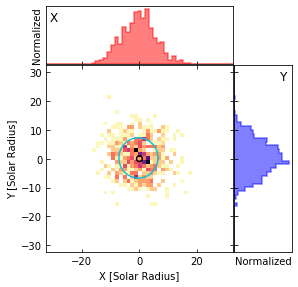

In [146]:


#(x_im_stat,y_im_stat,t_reach_1au_stat,weights_stat,t_free_stat
#    )=raystat.ImgXYtEstimate(r_vec_stat_avail,k_vec_stat_avail,t_reach_stat_avail,
#            tau_stat_avail,r_vec_0, k_vec_0,num_t_bins=60)

from sunRay.showPlot import XYDistributionImageHist
from matplotlib import rc
rc('text', usetex=False) 
XYDistributionImageHist(x_im_stat,y_im_stat,bins_data=np.linspace(-32.5,32.5,50)
            ,weights_data=weights_stat)

In [145]:
(np.sum(r_vec_stat_avail**2,0)**0.5) # buggy

array([59.53525758, 59.5352557 , 59.53524605, ..., 59.53528352,
       59.53518241, 59.53535539])

Total duration : 0.27513066114823836
Duration R/D : [0.0979  0.17723]
Vx R/D : 0.14638 , 0.95413
Vx R/D (c) : 0.33982 , 2.21507
Vy R/D : -0.15758 , -0.88649
Vy R/D (c) : -0.36582 , -2.05803
ERx R/D : 1.3454 , 0.19769
ERx R/D (Deg) : 0.71755 , 0.10543
ERx R/D : -0.12622 , 0.24827
ERx R/D (Deg) : -0.06732 , 0.13241
Size X : 0.39371 , 0.37683
Size X (Deg)0.20998 , 0.20097
Size Y : 0.62659 , 0.81669
Size Y (Deg)0.33418 , 0.43557
Offset R/D  x: 1.664151 , 1.742378
Offset R/D  y: 0.016487 , -0.020308


/home/amax/anaconda3/envs/torch15/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/amax/anaconda3/envs/torch15/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(<Figure size 270x360 with 3 Axes>,
 {'offset': [1.6641505381151342,
   1.7423775530293961,
   0.016486955618783515,
   -0.0203083023396494]})

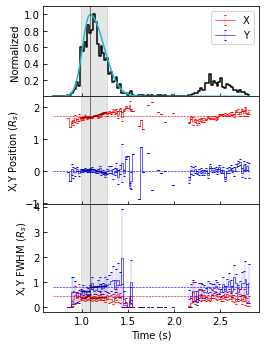

In [36]:
from sunRay.showPlot import XYVariationPlot

XYVariationPlot(x_im_stat,y_im_stat,t_reach_1au_stat,weights_stat,t_step = 0.02)

In [76]:
x_im_stat.dtype

dtype('float64')

time: 161 ms


In [ ]:
torch.sort(tau)[0][0]

In [49]:

t_collect

tensor([4.4008e-04, 1.5403e-02, 2.9925e-02, 4.4888e-02, 5.9410e-02, 7.4373e-02,
        8.8895e-02, 1.0386e-01, 1.1838e-01, 1.3334e-01, 1.4831e-01, 1.6283e-01,
        1.7779e-01, 1.9231e-01, 2.0728e-01, 2.2180e-01, 2.3706e-01, 2.5231e-01,
        2.6864e-01, 2.8506e-01, 3.0366e-01, 3.2405e-01, 3.4565e-01, 3.6915e-01,
        3.9385e-01, 4.2297e-01, 4.5586e-01, 4.9590e-01, 5.4317e-01, 6.0406e-01,
        6.8098e-01, 7.8152e-01, 9.4278e-01, 1.2286e+00, 2.3544e+00, 3.9940e+00,
        5.6832e+00, 7.3228e+00, 9.0120e+00, 1.0652e+01, 1.2341e+01, 1.4030e+01,
        1.5670e+01, 1.7359e+01, 1.8998e+01, 2.0688e+01, 2.2327e+01, 2.4016e+01,
        2.5656e+01, 2.7345e+01, 2.9034e+01, 3.0674e+01, 3.2363e+01, 3.4003e+01,
        3.5692e+01, 3.7331e+01, 3.9020e+01, 4.0660e+01, 4.2349e+01, 4.3989e+01,
        4.5678e+01, 4.7367e+01, 4.9007e+01, 5.0696e+01, 5.2335e+01, 5.4025e+01,
        5.5664e+01, 5.7353e+01, 5.8993e+01, 6.0682e+01, 6.2371e+01, 6.4011e+01,
        6.5700e+01, 6.7340e+01, 6.9029e+

time: 158 ms


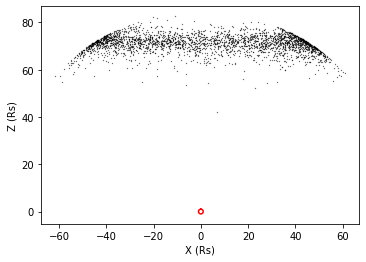

time: 847 ms


In [66]:
# plot the position in process
idx = -1
idx_select = np.sqrt(np.sum(r_vec_collect_local**2,axis=1)[-1,:])<84.7
plt.plot(r_vec_collect_local[idx,0,idx_select],r_vec_collect_local[idx,2,idx_select],'k.',markersize=0.5)
plt.plot(np.sin(np.linspace(0,np.pi*2,300)),
        np.cos(np.linspace(0,np.pi*2,300)),'r')
plt.xlabel('X (Rs)')
plt.ylabel('Z (Rs)')
plt.gca().set_aspect('equal')

In [53]:
idx_select=[np.sqrt(np.sum(r_vec_collect_local**2,axis=1)[-1,:])>84]

array([ True,  True,  True, ...,  True,  True,  True])

time: 167 ms


In [ ]:
# plot ray

idx_select = np.nonzero(((r_vec_collect_local[-1,0,:])**2+r_vec_collect_local[-1,1,:]**2)>0.5)
for num in (idx_select):
        plt.plot(r_vec_collect_local[:,2,num],r_vec_collect_local[:,0,num])
        plt.gca().set_aspect('equal')

In [ ]:
# inspect ray 
idx_select = np.nonzero(((r_vec_collect_local[-1,1,:])**2+r_vec_collect_local[-1,2,:]**2)<0.2)

idx_select = np.nonzero(((torch.sum(r_vec_collect[0,:,:].reshape(-1,3)*k_vec_collect[0,:,:].reshape(-1,3),1))).cpu()>1000)
#hst = plt.hist(k_vec_collect_local[0,:,idx_select])

#hst=plt.hist(torch.sum(r_vec_collect[99,:,idx_select].reshape(-1,3)*k_vec_collect[99,:,idx_select].reshape(-1,3),1).cpu().data.numpy(),100)
print(len(idx_select))
plt.plot(r_vec_collect_local[-1,0,idx_select],r_vec_collect_local[-1,2,idx_select],'k.',markersize=0.5)
plt.plot(np.sin(np.linspace(0,np.pi*2,300)),
        np.cos(np.linspace(0,np.pi*2,300)),'r')
plt.xlabel('X (Rs)')
plt.ylabel('Z (Rs)')
plt.gca().set_aspect('equal')

In [ ]:
idx_select = np.nonzero(((r_vec_collect_local[-1,1,:])**2+r_vec_collect_local[-1,2,:]**2)>1)

#hst=plt.hist(((torch.sum(r_vec_collect[0,:,:].reshape(-1,3)*k_vec_collect[0,:,:].reshape(-1,3),1))).numpy(),100)

hst=plt.hist(((torch.sum(r_vec[:,idx_select]*k_vec[:,idx_select],axis=0)).view(-1)).cpu().numpy(),500)

In [ ]:
hst=plt.hist(((torch.sum(r_vec.cpu()[:,:]*k_vec.cpu()[:,:],axis=0))).numpy(),100)

In [ ]:
plt.plot(k_vec_collect[0,0,:],k_vec_collect[0,1,:],'k.')

In [ ]:
freq = pfreq.omega_pe_r(ne_r,torch.Tensor(np.linspace(2,50,400)).to(dev_u))/(2*PI)

In [ ]:
cProfile.run('exec(open("sunRay_v0.py").read())')

In [ ]:
kc_cur/kc_norm

In [ ]:
t_collect.shape

In [ ]:
plt.plot(k_vec_collect[:,0,0],k_vec_collect[:,0,1],'k.')

In [ ]:
for num in range(100):
    plt.plot(r_vec_collect[:,2,num],r_vec_collect[:,1,num])
    plt.axis('equal')

In [ ]:
amp = lambda x : torch.sqrt(torch.sum(x.pow(2),axis=0))

plt.plot(amp(r_vec),amp(domega_pe_dxyz),'k.')

In [ ]:
domega_pe_dr.repeat(3,1).shape

In [ ]:
pfreq.omega_pe_r(ne_r,rr_cur)[0]

In [ ]:
rr_test = torch.linspace(20,100,100)
plt.plot(rr_test,pfreq.omega_pe_r(ne_r,rr_test))


In [ ]:
rr_cur

In [ ]:
start_r

In [ ]:
r_vec_collect.shape[2]

In [ ]:
# a test for the transformation

In [ ]:
# rotate the k vec into the r-z coordinate
kcx = - kx_cur*torch.sin(fi) + ky_cur*torch.cos(fi) 
kcy = (- kx_cur*costheta*torch.cos(fi) 
    - ky_cur*costheta*torch.sin(fi) + kz_cur*sintheta) 
kcz = (  kx_cur*sintheta*torch.cos(fi) 
    + ky_cur*sintheta*torch.sin(fi) + kz_cur*costheta)


kx_cur1 = (-kcx*torch.sin(fi) 
    -kcy*costheta*torch.cos(fi) +kcz*sintheta*torch.cos(fi) )
ky_cur1 = ( kcx*torch.cos(fi) 
    -kcy*costheta*torch.sin(fi) +kcz*sintheta*torch.sin(fi) )
kz_cur1 =  kcy*sintheta+kcz*costheta


In [ ]:
torch.max(kz_cur1/kz_cur-1)

In [ ]:
torch.atan(torch.Tensor([2]))

In [ ]:
plt.hist(torch.sum(r_vec*k_vec,0).cpu())

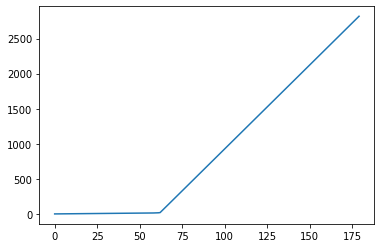

time: 479 ms


In [8]:
plt.plot(np.array(np.array(t_collect)))

In [58]:
np.savez('sunray_small_float32_20deg_0.3_0.1.npz', steps_N  = steps_N, collect_N = collect_N,
    photon_N = photon_N, start_r = start_r, start_theta = start_theta,
    start_phi  = start_phi, f_ratio  = f_ratio, epsilon = epsilon ,
    anis = anis, asym = asym,
    omega0=omega0.cpu(),
    freq0=freq0.cpu(),
    t_collect=t_collect.cpu(), tau=tau.cpu(),
    r_vec_collect_local=r_vec_collect_local,
    k_vec_collect_local=k_vec_collect_local,
    tau_collect_local = tau_collect_local)

time: 324 ms


torch.return_types.sort(
values=tensor([390.1856, 390.6868, 390.8470,  ..., 393.6197, 393.6219, 393.6273]),
indices=tensor([ 915, 3975, 3049,  ..., 1773,  250, 4476]))

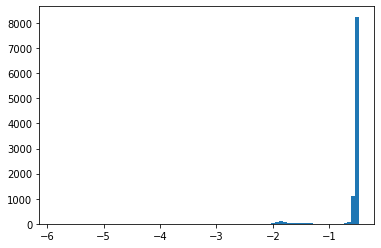

time: 648 ms


In [7]:
hst=plt.hist((-tau.cpu()),80)
torch.sort(rr_cur)

0.19202512404830618


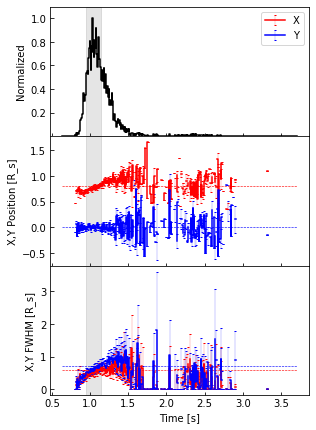

time: 2.17 s


In [8]:
from sunRay.showPlot import XYVariationPlot
gcf=XYVariationPlot(x_im_stat,y_im_stat,t_reach_stat,weights_stat,t_step = 0.008)

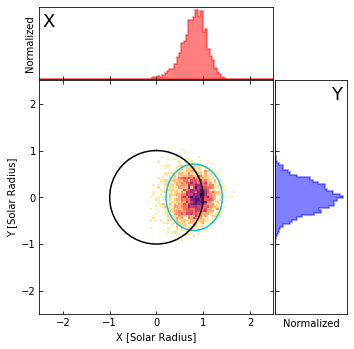

time: 1.14 s


In [9]:



from sunRay.showPlot import XYDistributionImageHist

XYDistributionImageHist(x_im_stat,y_im_stat,bins_data=np.linspace(-2.5,2.5,100)
            ,weights_data=weights_stat)

In [20]:
r_vec

tensor([[-17.6898, -10.5367,  14.8671,  ...,  39.0303,  31.4664,      nan],
        [  2.4447,  -9.2189, -19.9277,  ...,   6.3433, -31.0992,      nan],
        [ 46.2711,  47.4065,  42.8635,  ...,  30.7063,  22.0096,      nan]],
       device='cuda:0')

time: 29 ms


In [64]:
print(np.sqrt(np.sum((r_vec_collect_local[0,:,140])**2)))
        

1.7500131
time: 120 ms


In [7]:
import sunRay.tool as stool

print(stool.R_to_freq(1.75,1.1))
print(stool.R_to_freq(2.10428659,2))

stool.freq_to_R(35045076,2)

tensor([35045076.])
tensor([35045072.])


/home/amax/anaconda3/envs/torch15/lib/python3.8/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


array([2.10428659])

In [13]:
print(stool.freq_to_R(60e6,2))
print(stool.freq_to_R(65e6,2))
print(stool.freq_to_R(70e6,2))
print(stool.freq_to_R(75e6,2))


[1.78028301]
[1.74022034]
[1.70490162]
[1.67350443]


In [8]:
torch.atan2(torch.Tensor([1]),torch.Tensor([0]))

tensor([1.5708])

In [12]:
def a(a):
    return 1,2,3

In [2]:
import sunRay.densityModel as dm

(0.0, 15.2)

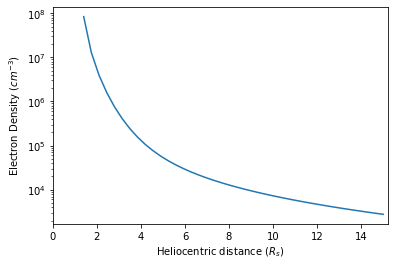

In [14]:
rrr=np.linspace(1.4,15,40)
#fig = plt.figure(figsize=[4,4],dpi=300)
ax = plt.gca()
ax.plot(rrr,dm.parkerfit(torch.Tensor(rrr)).cpu())
ax.set_xlabel(r'Heliocentric distance ($R_s$)')
ax.set_ylabel(r'Electron Density ($cm^{-3}$)')
ax.set_yscale('log')
ax.set_xlim([0,15.2])


(0.0, 15.2)

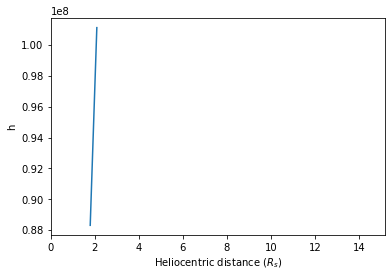

In [15]:
rrr=np.linspace(1.8,2.1
            ,40)
l_i = 1.0e5* rrr
l_0 = 0.23e0* 6.9e10*rrr**0.82
    
ax = plt.gca()
ax.plot(rrr,l_0**(2./3.) * l_i**(1./3.)/ (np.pi**(3./2.)))
ax.set_xlabel(r'Heliocentric distance ($R_s$)')
ax.set_ylabel(r'h')
#ax.set_yscale('log')
ax.set_xlim([0,15.2])


(0.0, 15.2)

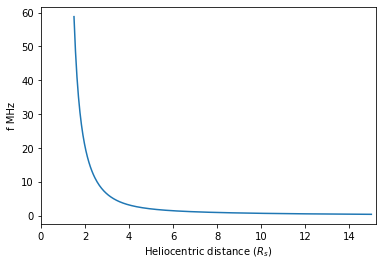

In [25]:
rrr=np.linspace(1.5,15,400)
#fig = plt.figure(figsize=[4,4],dpi=300)
ax = plt.gca()
ax.plot(rrr,8.93e3* (dm.parkerfit(torch.Tensor(rrr)).cpu())**(0.5) /1e6)
ax.set_xlabel(r'Heliocentric distance ($R_s$)')
ax.set_ylabel(r'f MHz')
#ax.set_yscale('log')
ax.set_xlim([0,15.2])

In [21]:
8.93e3* (dm.parkerfit(torch.Tensor([1.75])).cpu())**(0.5) /1e6

tensor([31.8592])

(0.0, 15.2)

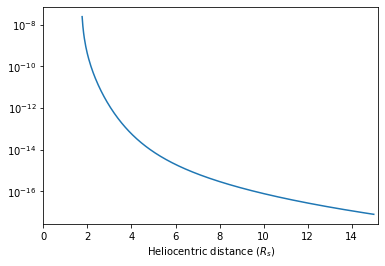

In [17]:
rrr=np.linspace(1.76,15,400)
#fig = plt.figure(figsize=[4,4],dpi=300)

wpe = 8.93e3* (dm.parkerfit(torch.Tensor(rrr)).numpy())**(0.5) * 2 * np.pi
w = 8.93e3* (dm.parkerfit(torch.Tensor([1.75])).numpy())**(0.5) * 2 * np.pi*1.1
eps = 0.3

l_i = 1.0e5* rrr
l_0 = 0.23e0* 6.9e10*rrr**0.82

h=l_0**(2./3.) * l_i**(1./3.)/ (np.pi**(3./2.))

ax = plt.gca()
ax.plot(rrr,np.pi/2*eps**2/h*wpe**4/(w**2-wpe**2)**2)
ax.set_xlabel(r'Heliocentric distance ($R_s$)')
ax.set_ylabel(r'')
ax.set_yscale('log')
ax.set_xlim([0,15.2])

In [40]:

rrr=2.1

l_i = 1.0e5* rrr
l_0 = 0.23e0* 6.9e10*rrr**0.82

h=l_0**(2./3.) * l_i**(1./3.)/ (np.pi**(3./2.))

In [39]:
h/1e5

861.3902630754685

In [41]:
h/1e5

1011.2987136501002

In [16]:
wpe = 8.93e3* (dm.parkerfit(torch.Tensor(rrr)).numpy())**(0.5) * 2 * np.pi


In [20]:
32 *1.1

35.2